In [31]:
# install libraries
!pip install scikit-learn transformers opencv-python matplotlib torch
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/sm/xdqhn25x4j555b_4m204nff00000gn/T/pip-req-build-t7jjvkkm
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/sm/xdqhn25x4j555b_4m204nff00000gn/T/pip-req-build-t7jjvkkm
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


## Import libraries and modules

In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
import cv2
import torch
from transformers import AutoImageProcessor, ResNetModel

## Dataset Analysis

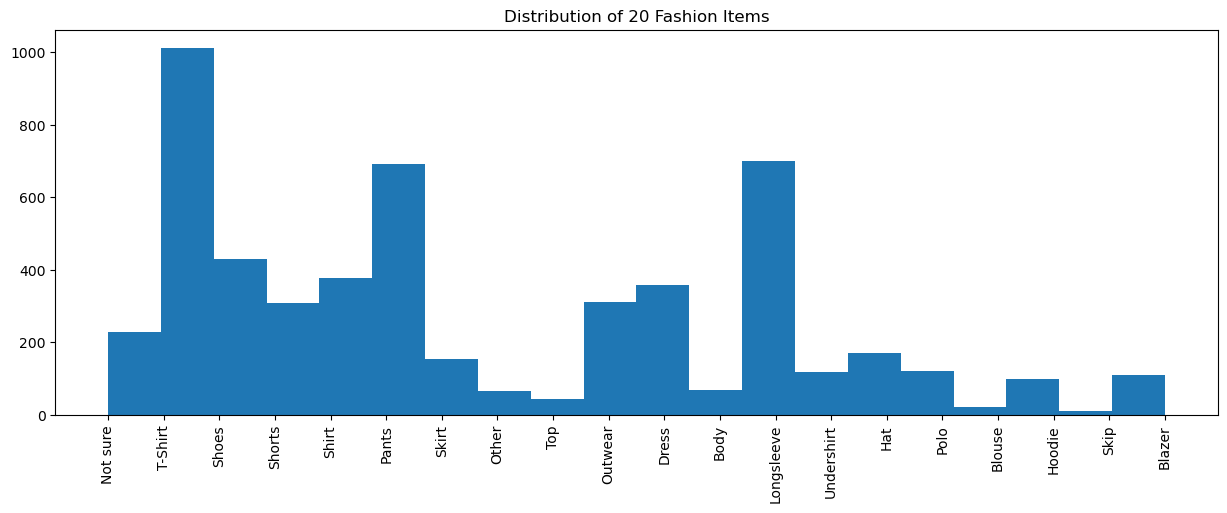

In [33]:
# load the dataset
data = pd.read_csv('images.csv')

# analysis
image_ids = data['image'].tolist()
labels = data['label'].tolist()
kids = data['kids'].tolist()
unique_items = set(labels)

# visualize the different categories of fashion items
plt.figure(figsize=(15, 5))
plt.title("Distribution of {} Fashion Items".format(len(unique_items)))
plt.hist(labels, bins=len(unique_items))
plt.xticks(rotation=90)
plt.show()

## Data cleansing

In [34]:
# remove the records with the label Skip, because the images with skip labels are not present in the images folder or occluded
data = data[data['label'] != 'Skip']
image_ids = data['image'].tolist()
labels = data['label'].tolist()
kids = data['kids'].tolist()
unique_items = set(labels)

## Load the ResNet-50 model for image features extraction

In [35]:
# load the resnet model for image features extraction
model_name = "microsoft/resnet-50"
resnet_img_processor = AutoImageProcessor.from_pretrained(model_name)
resnet_model = ResNetModel.from_pretrained(model_name)

## Helper functions

In [37]:
def extract_image_features(img_path):
    # load and preprocess the image for the ResNet model
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # resize the image to 224x224 to be compatible with ResNet model input size
    image = cv2.resize(image, (224, 224))
    # convert the image to PyTorch tensor and change dimensions to CxHxW as expected by the ResNet model
    image = torch.tensor(image).permute(2, 0, 1).float()
    inputs = resnet_img_processor(images=[image], return_tensors="pt")

    # forward pass to get features without the final classification layer
    with torch.no_grad():
        outputs = resnet_model(**inputs)

    # use the last convolutional layer output as feature vector
    # it is a 2048-dimensional vector
    feature_vector = outputs.pooler_output.squeeze()

    return feature_vector

# returns the indices of the most similar images to the test image
def get_recommendations(test_img_path, count=5):
    # get feature vector for the test image
    test_img_features = extract_image_features(test_img_path)
    # calculate similarity scores between the test image and all the images in the dataset
    similarities = cosine_similarity([test_img_features], feature_vectors_matrix).flatten()
    # sort the similarity scores in descending order, meaning similar items will show up first
    similar_indices = np.argsort(similarities)[::-1]
    # remove the exact match because it will be the test image itself
    similar_indices = [idx for idx in similar_indices if similarities[idx] < 1.0]
    return similar_indices[:count]


def display_test_and_recommended_images(test_img_path, recommendations_count=5):
    # load the test image
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    # get the recommended images against the test image
    recommended_img_indexes = get_recommendations(test_img_path, recommendations_count)
    recommended_images = [(cv2.imread(os.path.join("images", image_ids[idx] + ".jpg"))) for idx in
                          recommended_img_indexes]
    subplots_count = recommendations_count + 1
    # plot the test image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, subplots_count, 1)
    plt.imshow(test_img)
    plt.title("Test Image")
    plt.axis('off')

    # plot the recommended images
    for i, img in enumerate(recommended_images):
        plt.subplot(1, subplots_count, i + 2)
        # convert the image to RGB format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title("Recommended Image " + str(i + 1))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Extract features for all the images in the dataset

In [38]:
# extract features for the images in the dataset
feature_vectors = [extract_image_features(os.path.join("images", img_id + ".jpg")) for img_id in image_ids]

In [39]:
print("There are {} images feature vectors".format(len(feature_vectors)))
print(feature_vectors[0].shape)

There are 5391 images feature vectors
torch.Size([2048])


In [42]:
# calculate cosine similarity between the feature vectors
feature_vectors_matrix = np.stack(feature_vectors)
print(type(feature_vectors_matrix[0]))
# save the feature matrix to a file
np.save("embeddings/feature_matrix.npy", feature_vectors_matrix)


<class 'numpy.ndarray'>


## Load the feature matrix

In [43]:
# load the feature matrix
feature_vectors_matrix = np.load("embeddings/feature_matrix.npy")

## Test the recommendation system

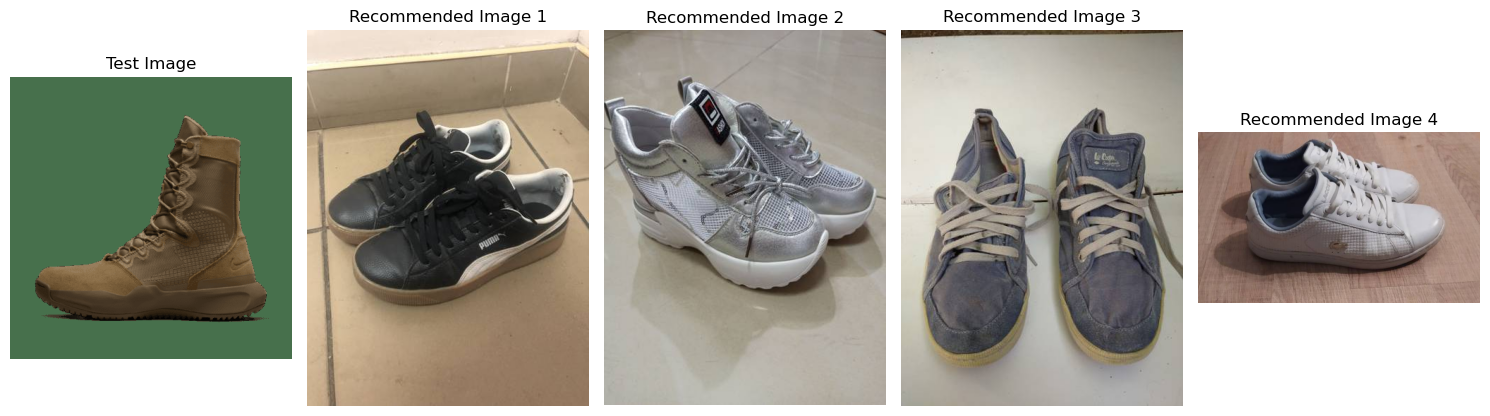

In [44]:
# load the test image
test_img_path = os.path.join("test_images", "2.png")
# load the test image
display_test_and_recommended_images(test_img_path, recommendations_count = 4)


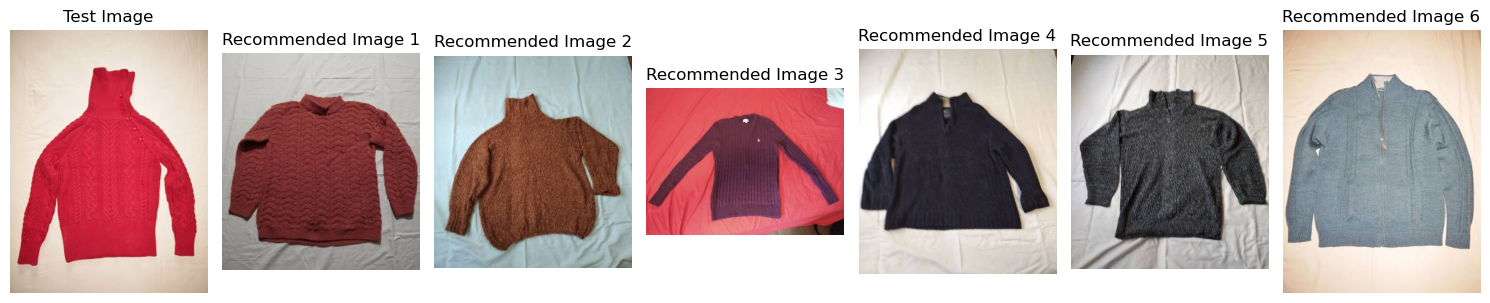

In [45]:
# load the test image
test_img_path = os.path.join("images", "0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg")
display_test_and_recommended_images(test_img_path, recommendations_count=6)